# **IMPORTADO DE MÓDULOS/FUNCIONES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d


from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2

import tensorflow as tf
tf.version.VERSION 

2024-06-11 11:42:53.472097: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 11:42:53.496273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 11:42:53.889093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.16.1'

In [2]:
V55 = np.load('/home/josea/Co60_5cm_5cm.npy')
V28 = np.load('/home/josea/Co60_2cm_8cm.npy')
V82 = np.load('/home/josea/Co60_8cm_2cm.npy')

In [3]:
from functions import gauss, gauss_fit, weights_definition, create_and_delay_pulse_pair, pulso, pulso_escalon, pulso_sigmoid, get_mean_pulse_from_set
from Models import model_definition_manual_weight_initialization,  Fit_to_exp_model, custom_loss, CustomOutputLayer

# **INTERPOLATION**

In [4]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28, kind = 'cubic', axis = 1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55, kind = 'cubic', axis = 1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82, kind = 'cubic', axis = 1)
new_V82 = interp_func_V82(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


In [5]:
#----------------------------- Start and stop points for pulse cropping -----------------
start = 50*EXTRASAMPLING
stop = 80*EXTRASAMPLING

#----------------------------- Create array of all positions ----------------------------
pulsos_reales = np.concatenate((new_V28,new_V55,new_V82), axis = 0)
print(pulsos_reales.shape)

(736, 4800, 2)


In [6]:
#------------------------------------- Basic definitions ----------------------------------------
Ncasos_sim = 0
Ncasos_real = int(pulsos_reales.shape[0])
Nc = 2

t = np.linspace(0,Nt,Nt_new)
#t0 = 65 + np.random.randint(5, size = Ncasos) 
t0 = 550 + np.random.randint(100, size = int(Ncasos_sim + Ncasos_real))
#t0 = 78 + np.random.randint(5, size = int(Ncasos_sim + Ncasos_real)) 

# **GENERATE MEAN PULSE PER DETECTOR**

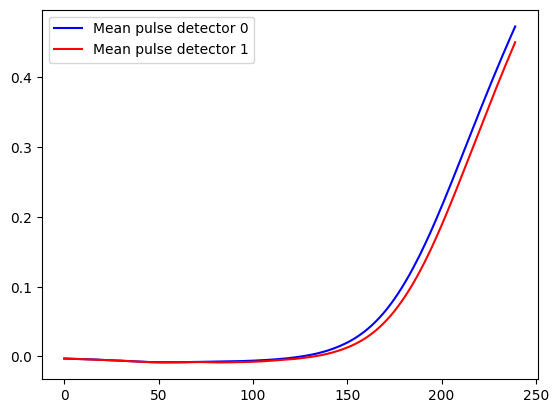

In [7]:
mean_pulse_dec0 = get_mean_pulse_from_set(new_V55, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(new_V55, channel = 1)

#-------------------------------------- Plot cropped mean pulses -----------------------------
plt.plot(mean_pulse_dec0[start:stop], 'b-', label = 'Mean pulse detector 0')
plt.plot(mean_pulse_dec1[start:stop], 'r-', label = 'Mean pulse detector 1')
plt.legend()

# **PREPROCESSING**

In [8]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec0 = 3
tau_drop_dec0 = 150
Photon_yield = 100
center_window_dec0 = 0.3
rise_window_dec0 = 0.3

#--------------------------------- Detector 1 definitions -------------------------
tau_rise_dec1 = 3
tau_drop_dec1 = 150
Photon_yield = 100
center_window_dec1 = 0.3
rise_window_dec1 = 0.3

Text(0, 0.5, 'Voltage [A.U]')

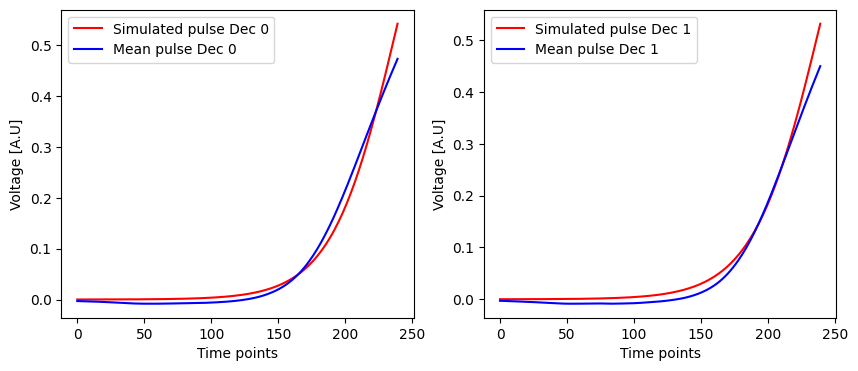

In [9]:
#pulso_original_dec0 = pulso(t, 70, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)
#pulso_original_dec1 = pulso(t, 70, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)
pulso_original_dec0 =  pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
pulso_original_dec1 =  pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)

plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(pulso_original_dec0[start:stop],'r-', label = 'Simulated pulse Dec 0')
plt.plot(mean_pulse_dec0[start:stop],'b-', label = 'Mean pulse Dec 0')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')

plt.subplot(122)
plt.plot(pulso_original_dec1[start:stop],'r-', label = 'Simulated pulse Dec 1')
plt.plot(mean_pulse_dec1[start:stop],'b-', label = 'Mean pulse Dec 1')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')

In [10]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec0 = np.zeros((Ncasos_sim,Nt_new))
INPUT_dec1 = np.zeros((Ncasos_sim,Nt_new))


for i in range(Ncasos_sim):
  centro = t0[i]
  #PULSO_dec0 = pulso(t, centro,  tau_rise = tau_rise_dec0)
  #PULSO_dec1 = pulso(t, centro, tau_rise = tau_rise_dec1)
  PULSO_dec0 = pulso_escalon(t, centro, A = 0.7)
  PULSO_dec1 = pulso_escalon(t, centro, A = 0.7)
  #PULSO_dec0 = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
  #PULSO_dec1 = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = False)
  INPUT_dec0[i,:] = PULSO_dec0
  INPUT_dec1[i,:] = PULSO_dec1


In [11]:
#-------------------------------- Delay simulated pulses --------------------------------------------
INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(INPUT_dec0, new_time_step, delay_steps = 32, NOISE = True)
INPUT_dec1, REF_dec1 = create_and_delay_pulse_pair(INPUT_dec1, new_time_step, delay_steps = 32, NOISE = True)

#--------------------------------- Delay mean pulse ----------------------------------------------------
INPUT2_dec0, REF2_dec0 = create_and_delay_pulse_pair(pulsos_reales[:Ncasos_real,:,0], new_time_step, delay_steps = 32, NOISE = True)
INPUT2_dec1, REF2_dec1 = create_and_delay_pulse_pair(pulsos_reales[:Ncasos_real,:,1], new_time_step, delay_steps = 32, NOISE = True)

#--------------------------------- Create train set ----------------------------------------------------
trainX_dec0 = np.concatenate((INPUT_dec0[:,start:stop,:], INPUT2_dec0[:,start:stop,:]), axis = 0)
trainX_dec1 = np.concatenate((INPUT_dec1[:,start:stop,:], INPUT2_dec1[:,start:stop,:]), axis = 0)

REF_train_dec0 = np.concatenate((REF_dec0[:], REF2_dec0[:]))
REF_train_dec1 = np.concatenate((REF_dec1[:], REF2_dec1[:]))

<Axes: title={'center': 'Detector 1'}>

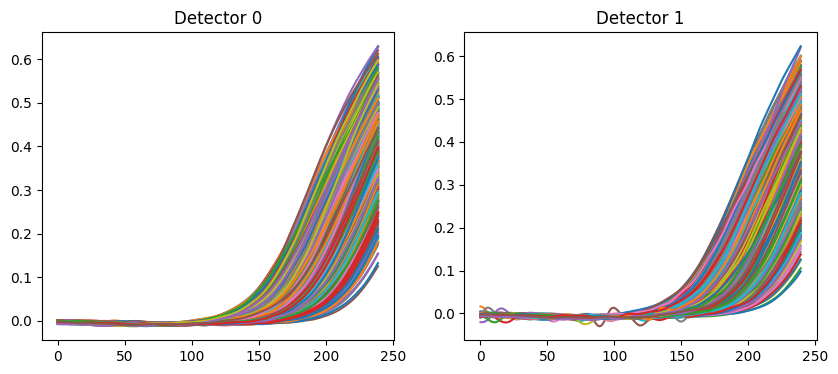

In [12]:
plt.figure(figsize = (10,4))

plt.subplot(121)
for i in range(trainX_dec0.shape[0]):
  plt.plot(trainX_dec0[i,:,0])
plt.title('Detector 0')
plt.subplot(122)
for i in range(trainX_dec1.shape[0]):
  plt.plot(trainX_dec1[i,:,0])
plt.title('Detector 1')
plt.subplot(122)


# **MULTIPLE TRAINING**

In [13]:
REFERENCE_PULSE_dec0 = np.tile(mean_pulse_dec0[start:stop], (new_V82.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(mean_pulse_dec1[start:stop], (new_V82.shape[0],2,1)).swapaxes(1,2)

In [47]:
tf.config.run_functions_eagerly(True)
def Fit_to_exp_model(N_time_points, NN = 32, STD_INIT = 1):

  inputA = Input(shape=(N_time_points,))
  inputB = Input(shape=(N_time_points,))

  #x1 = Dense(NM, activation="relu", kernel_initializer = Constant(kernel_weights), bias_initializer = 'zeros')
  x1 = Dense(NN, activation = "relu", kernel_initializer = initializers.RandomNormal(mean = 0.0, stddev = STD_INIT), kernel_regularizer = l2(0.01))
  x2 = Dense(NN, activation = "relu", kernel_initializer = initializers.RandomNormal(mean = 0.0, stddev = STD_INIT), kernel_regularizer = l2(0.01))
  x3 = Dense(NN, activation = "relu", kernel_initializer = initializers.RandomNormal(mean = 0.0, stddev = STD_INIT), kernel_regularizer = l2(0.01))
  x4 = Dense(NN, activation = "relu", kernel_initializer = initializers.RandomNormal(mean = 0.0, stddev = STD_INIT), kernel_regularizer = l2(0.01))
  x5 = Dense(1, activation = "linear")

  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  op4A = x4(op3A)
  outA = x5(op4A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  op4B = x4(op3B)
  outB = x5(op4B)
  
  model = Model(inputs = [inputA, inputB], outputs = outA - outB)
  return model 


def custom_loss(y_true, y_pred):     #, t, inputA, inputB):
    #outA1, outB1 = y_pred

    # Ensure the shapes are correct
    #outA = tf.convert_to_tensor(outA)
    #outB = tf.convert_to_tensor(outB)
    #inputA = tf.convert_to_tensor(inputA)
    #inputB = tf.convert_to_tensor(inputB)
    #
    #
    ## Access individual neurons from outA
    #outA1, outA2, outA3, outA4 = tf.split(outA, num_or_size_splits = 4, axis=-1)
    #outB1, outB2, outB3, outB4 = tf.split(outB, num_or_size_splits = 4, axis=-1)

    ## Analytical pulse calculations
    #analytical_pulse_A = outA2 * (1 - tf.exp(-(t - outA1) / (1-3 + outA3)) * tf.exp(-(t - outA1) / (1e-3 + outA4)))
    #analytical_pulse_B = outB2 * (1 - tf.exp(-(t - outB1) / (1-3 + outB3)) * tf.exp(-(t - outB1) / (1e-3 + outB4)))

    loss1 = tf.reduce_mean(tf.square(y_pred - y_true))
    #loss2 = tf.reduce_mean(tf.square(outA2 - outB2))
    #loss3 = tf.reduce_mean(tf.square(analytical_pulse_A - inputA))
    #loss4 = tf.reduce_mean(tf.square(analytical_pulse_B - inputB))
    
    return loss1 #+ loss2 + loss3 + loss4

In [51]:
def train_model(model, optimizer, trainX, REF_train, REFERENCE_PULSE, time_array, channel = 0, epochs = 75, batch_size = 32):
    num_batches = trainX.shape[0] // batch_size

    OUT_V28_epoch = []
    OUT_V55_epoch = []
    OUT_V82_epoch = []
    
    
    for epoch in range(epochs):
        epoch_loss = 0
        
        for batch in range(num_batches):
            x_batch = [trainX[batch*batch_size:(batch+1)*batch_size, :, 0].astype(np.float32), trainX[batch*batch_size:(batch+1)*batch_size, :, 1].astype(np.float32)]
            y_batch = REF_train[batch*batch_size:(batch+1)*batch_size].astype(np.float32)
            
            with tf.GradientTape() as tape:
                y_pred = model(x_batch, training = True)
                loss = custom_loss(y_batch, y_pred)   #, time_array, x_batch[0], x_batch[1])

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss += loss.numpy()
        
        OUT_V82 = model.predict([new_V82[:,start:stop,channel], REFERENCE_PULSE[:new_V82.shape[0],:,0]])
        OUT_V55 = model.predict([new_V55[:,start:stop,channel], REFERENCE_PULSE[:new_V55.shape[0],:,0]])
        OUT_V28 = model.predict([new_V28[:,start:stop,channel], REFERENCE_PULSE[:new_V28.shape[0],:,0]])
        
        OUT_V28_epoch.append(OUT_V28)
        OUT_V55_epoch.append(OUT_V55)
        OUT_V82_epoch.append(OUT_V82)
            
        print(f"Epoch {epoch+1}, Loss: {epoch_loss / num_batches}")
    

    OUT_V28 = np.array(OUT_V28_epoch, dtype = 'object')
    OUT_V55 = np.array(OUT_V55_epoch, dtype = 'object')
    OUT_V82 = np.array(OUT_V82_epoch, dtype = 'object')

    OUT_V28 = np.array(OUT_V28, dtype = 'float64')
    OUT_V55 = np.array(OUT_V55, dtype = 'float64')
    OUT_V82 = np.array(OUT_V82, dtype = 'float64')
    return OUT_V28, OUT_V55, OUT_V28

In [57]:
model_dec0 = Fit_to_exp_model(int(stop-start), NN = 32, STD_INIT = 1)
model_dec1 = Fit_to_exp_model(int(stop-start), NN = 32, STD_INIT = 1)

opt_dec0 = tf.keras.optimizers.AdamW(learning_rate = 5e-3)
opt_dec1 = tf.keras.optimizers.AdamW(learning_rate = 5e-3)

OUT_DEC0_V28, OUT_DEC0_V55, OUT_DEC0_V82 = train_model(model_dec0, opt_dec0, trainX_dec0, REF_train_dec0, REFERENCE_PULSE_dec0, tiempo_new[start:stop], channel = 0, epochs = 500, batch_size = 16)
OUT_DEC1_V28, OUT_DEC1_V55, OUT_DEC1_V82 = train_model(model_dec1, opt_dec1, trainX_dec1, REF_train_dec1, REFERENCE_PULSE_dec1, tiempo_new[start:stop], channel = 1, epochs = 500, batch_size = 16)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/home/josea/.local/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1, Loss: 4.509937683849231
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 2, Loss: 0.2732026037638602
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 3, Loss: 0.20497110923347267
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 4, Loss: 0.17166863317074982
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 5, Loss: 0.15212128246607987
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 6, Loss: 0.15152032300829887
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 7, Loss: 0.15907046619964682
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [58]:
#TOFN_V82 = OUTA_DEC0_REF_V82[:,0] - OUTA_DEC1_REF_V82[:,0]
#TOFN_V55 = OUTA_DEC0_REF_V55[:,0] - OUTA_DEC1_REF_V55[:,0]
#TOFN_V28 = OUTA_DEC0_REF_V28[:,0] - OUTA_DEC1_REF_V28[:,0]

TOFN_V82 = np.squeeze(OUT_DEC0_V82) - np.squeeze(OUT_DEC1_V82)
TOFN_V55 = np.squeeze(OUT_DEC0_V55) - np.squeeze(OUT_DEC1_V55)
TOFN_V28 = np.squeeze(OUT_DEC0_V28) - np.squeeze(OUT_DEC1_V28)


In [59]:
centroid_V28 = np.mean(TOFN_V28, axis = 1) - np.mean(TOFN_V55, axis = 1)
centroid_V82 = np.mean(TOFN_V82, axis = 1) - np.mean(TOFN_V55, axis = 1)
mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
mean_std = (np.std(TOFN_V82, axis = 1) + np.std(TOFN_V55, axis = 1) + np.std(TOFN_V28, axis = 1)) / 3
epsilon = np.sqrt(mean_error_centroid**2 + mean_std**2)

In [60]:
print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))

(array([430]),) 0.2002366573729423



V82: CENTROID(ns) = -0.014  FWHM(ns) = 0.030  std(ns) = 0.013
V55: CENTROID(ns) = -0.000  FWHM(ns) = 0.028  std(ns) = 0.012
V28: CENTROID(ns) = -0.014  FWHM(ns) = 0.030  std(ns) = 0.013


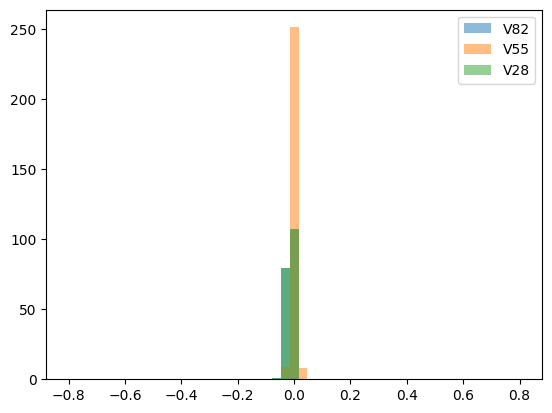

In [61]:
index = 430
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins = 51
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82[index,:] - np.mean(TOFN_V55[index,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55[index,:] - np.mean(TOFN_V55[index,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28[index,:] - np.mean(TOFN_V55[index,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))